In [1]:
import pickle
import h5py 
import polychrom
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)

import seaborn as sns
import pyBigWig as bw
import matplotlib.pyplot as plt

import simtk.openmm 
import os
import json
import shutil

import warnings
import glob

import time
from multiprocessing import Pool


from scipy.sparse import coo_matrix as coo



from scripts import *

#import claster
%load_ext autoreload
%autoreload 2

In [2]:
rna_seq_dir = '/mnt/a/!Work/tmp/chick_oocytes/galGal_T2T/rnaseq'
genes_df = gtf_reader(f'{rna_seq_dir}/valid_transcripts.gtf', transcripts_only=True)
full_df =  pd.read_csv(f'{rna_seq_dir}/full.tsv', sep='\t')

In [3]:
mask = (genes_df['type'] == 'transcript') & (genes_df['FPKM'] > 0)
max_fpkm = genes_df['FPKM'][mask].max()
genes_df['len'] = genes_df['end'] - genes_df['start']
lib_depth = (genes_df[mask]['cov']*genes_df[mask]['len']).sum()
min_rnap_sep = 30 # bp
frag_len = 151
genes_df.loc[mask, 'rnap_sep'] = genes_df[mask][['len', 'FPKM']].apply(lambda x: (1e9 * x[0]) / (x[1] * lib_depth * 2 * frag_len), axis=1)
# sns.histplot(genes_df[mask]['rnap_sep'], log_scale=(10,10))
# plt.show(close=True)

In [4]:
sum(genes_df[mask]['rnap_sep'] < 30)/len(genes_df[mask]['rnap_sep'])*100

1.80089587713685

In [5]:
sum(genes_df[mask]['rnap_sep'] > genes_df[mask]['len'])/len(genes_df[mask]['rnap_sep'])*100

6.773928146996984

In [6]:
args = {
    'BEADSIZE': 45, # bp
    'RNAP_VEL': 100, # bp/s
    'COND_VEL': 1e3, # bp/s
    'RNAP_REM_COND_PROB': 1e-2,
    'BOUNDTIME': 1e0,
    'COND_STEP_OVER_RNAP_PROB': 1e-2,
    'Diffusion_prob': 1e-4,
    'Cohesin_separator': 25e3,
}
args['TIMESTEP'] = args['BEADSIZE'] / args['COND_VEL'] # sec, extruder vel ~1 kbp/s and one step ~45 bp
args['LIFETIME'] = 2e3 / args['TIMESTEP']
args['LIFETIME_STALLED'] = args['LIFETIME']
args['ave_loop_size'] = 250e3

In [7]:
# full_df[full_df['transcript_id']=='FORW.1.1']

In [8]:
genes_df[(genes_df['len']>50e3) & (genes_df['rnap_sep'] < 5e2)]

type  chrom      start        end direction    gene_id  \
222    transcript   chr1   15706517   15759306         -    REV.115   
2959   transcript  chr10    2396080    2452166         +  FORW.6884   
4405   transcript  chr12   15587214   15640564         +  FORW.7633   
4450   transcript  chr12   18040640   18097860         -   REV.7494   
5506   transcript  chr14   14998027   15052740         -   REV.8018   
5602   transcript  chr15    3505643    3568483         +  FORW.8236   
6380   transcript  chr17    8768517    8823100         -   REV.8449   
6823   transcript  chr18   11177407   11235830         +  FORW.8847   
8752   transcript   chr2   96904320   96958630         -   REV.2180   
9035   transcript   chr2  115220150  115291157         +  FORW.2418   
10051  transcript  chr21    4698419    4751357         -   REV.9187   
10144  transcript  chr22     627010     688518         +  FORW.9412   
10209  transcript  chr22    2201560    2258678         -   REV.9276   
10607  transcript  chr23    6460899    6515557         +  FORW.9623   
12250  transcript   chr3    4556673    4607354         +  FORW.2665   
13223  transcript   chr3   51858691   51919970         -   REV.3020   
16272  transcript   chr4   48577285   48640652         +  FORW.4217   
16329  transcript   chr4   50067860   50119874         -   REV.4080   
18144  transcript   chr5   39131428   39202433         +  FORW.5152   
19040  transcript   chr6   16957806   17019282         +  FORW.5582   
19083  transcript   chr6   18632737   18685747         -   REV.5480   
19122  transcript   chr6   20431133   20482452         +  FORW.5619   
19548  transcript   chr7     231638     297238         -   REV.5708   
20038  transcript   chr7   22291035   22345593         +  FORW.6104   
20446  transcript   chr8    5237606    5307321         -   REV.6146   
20502  transcript   chr8    6650466    6700827         +  FORW.6325   
21334  transcript   chr9   13263060   13325138         +  FORW.6736   
21513  transcript   chr9   20365239   20418609         -   REV.6699   

      transcript_id         TPM       FPKM       cov    len    rnap_sep  
222       REV.115.4  133.734407  11.112469  0.116577  52789  498.802664  
2959    FORW.6884.2  146.227307  12.150548  0.212673  56086  484.679298  
4405    FORW.7633.1  147.931454  12.292152  0.162699  53350  455.724505  
4450     REV.7494.4  172.476368  14.331677  0.250647  57220  419.224581  
5506     REV.8018.3  173.713537  14.434477  0.205673  54713  398.002088  
5602    FORW.8236.3  201.400190  16.735060  0.187778  62840  394.280034  
6380     REV.8449.1  228.209124  18.962710  0.311342  54583  302.240655  
6823    FORW.8847.2  164.502529  13.669102  0.226623  58423  448.786475  
8752     REV.2180.1  187.691390  15.595947  0.148039  54310  365.648620  
9035    FORW.2418.7  181.214004  15.057718  0.142789  71007  495.151265  
10051    REV.9187.3  136.238660  11.320556  0.201594  52938  491.016007  
10144   FORW.9412.1  326.547156  27.133968  0.348686  61508  238.020402  
10209    REV.9276.1  184.275680  15.312123  0.280630  57118  391.681856  
10607   FORW.9623.3  216.507596  17.990388  0.264627  54658  319.013517  
12250   FORW.2665.1  147.322220  12.241529  0.187921  50681  434.715780  
13223    REV.3020.2  162.624085  13.513015  0.157558  61279  476.162607  
16272   FORW.4217.3  160.177973  13.309759  0.158048  63367  499.906563  
16329    REV.4080.4  155.737539  12.940788  0.236398  52014  422.041764  
18144   FORW.5152.3  241.297501  20.050270  0.230280  71005  371.847266  
19040   FORW.5582.4  173.183542  14.390438  0.152385  61476  448.567155  
19083    REV.5480.1  155.507484  12.921671  0.191964  53010  430.759629  
19122   FORW.5619.3  146.986766  12.213655  0.194275  51319  441.192819  
19548    REV.5708.5  176.511171  14.666943  0.263582  65600  469.634646  
20038   FORW.6104.1  147.883492  12.288167  0.152627  54558  466.194589  
20446    REV.6146.3  194.859839  16.191599  0.167539  69715  452.097783  
20502   FORW.6325.4  247.7321

In [76]:
chosen_slice_str = 'chr0:000,000-2,250,000'

chosen_slice = slice_str_parser(chosen_slice_str)

N = chosen_slice[2]//args['BEADSIZE'] - chosen_slice[1]//args['BEADSIZE']
N = N*2 # If double strands
args['N'] = N
N/2

50000.0

In [77]:
mask = (genes_df['chrom'] == chosen_slice[0]) & (genes_df['start'] > chosen_slice[1]) & (genes_df['end'] < chosen_slice[2]) & \
        (genes_df['type'] == 'transcript') & (genes_df['FPKM'] > 0.0) # & (genes_df['gene_id'] == 'FORW.7360')
chosen_genes = genes_df[mask]
chosen_genes

Empty DataFrame
Columns: [type, chrom, start, end, direction, gene_id, transcript_id, TPM, FPKM, cov, len, rnap_sep]
Index: []

In [78]:
chosen_genes_beads = genes_to_beads_converter(chosen_genes, full_df, args)

In [79]:
# chosen_genes_beads

In [80]:
chosen_genes_beads = []

rnap_sep = 1e3 # bp
gen_len = 1000 # beads
start_pos = 6000 # beads
direction = 1
end_pos = start_pos + direction * gen_len
load_prob = args['TIMESTEP'] / (rnap_sep / args['RNAP_VEL'])
introns = []
chosen_genes_beads += [[start_pos, direction, end_pos, load_prob, introns]]
chosen_genes_beads += [[N - start_pos - 1, -1*direction, N - end_pos - 1, load_prob, introns]] # Make sister chromatid gene

gene_gap = 100

rnap_sep = 1e3 # bp
gen_len = 500
start_pos = end_pos + gene_gap + gen_len
direction = -1
end_pos = start_pos + direction * gen_len
load_prob = args['TIMESTEP'] / (rnap_sep / args['RNAP_VEL'])
introns = []
chosen_genes_beads += [[start_pos, direction, end_pos, load_prob, introns]]
chosen_genes_beads += [[N - start_pos - 1, -1*direction, N - end_pos - 1, load_prob, introns]] # Make sister chromatid gene

chosen_genes_beads

[[6000, 1, 7000, 0.0045, []],
 [93999, -1, 92999, 0.0045, []],
 [7600, -1, 7100, 0.0045, []],
 [92399, 1, 92899, 0.0045, []]]

In [86]:
# args

In [87]:
nproc = 8
batch_to_save = nproc

N_coh = int(np.round(np.round((N/2)*args['BEADSIZE']/args['Cohesin_separator'])))
maxcondesins = max(int(np.round((N)*args['BEADSIZE']/(args['ave_loop_size']))), 2)
args['N_coh'] = N_coh
args['maxcondesins'] = maxcondesins

print(f'N_coh {N_coh}')
print(f'maxcondesins {maxcondesins}')

steps_wo_saving = int(4.5e2)
initiate_steps = int(((chosen_genes['len'].max()+1) / args['RNAP_VEL']) / args['TIMESTEP'])
restart_simulation = nproc
steps = int(2e2)*4
args['steps_wo_saving'] = steps_wo_saving
args['steps'] = steps

print(f'initiate_steps {initiate_steps}')

folder_name = f'./test_multiproc'
if os.path.exists(folder_name):
    shutil.rmtree(folder_name)
os.mkdir(folder_name)

with open(f'{folder_name}/info', 'w') as file:
    file.write(chosen_slice_str)
json.dump(args, open(f'{folder_name}/info.json', 'w'), indent = 4)


max_steps = int(steps * restart_simulation)
assert max_steps > 0
# assert (trajectory_len // steps_wo_saving) % steps == 0
assert max_steps % steps == 0
max_rnaps = sum([abs(x[0]-x[2])+1 for x in chosen_genes_beads])

N_coh 90
maxcondesins 18
initiate_steps 0


In [88]:
%%time

with h5py.File(f'{folder_name}/RNAp_pos_brists.h5', mode='w') as RNApfile, \
    h5py.File(f'{folder_name}/Cohesins_positions.h5', mode='w') as COHfile, \
    h5py.File(f'{folder_name}/Condensins_positions.h5', mode='w') as CONDfile:
    
    RNApfile.attrs["N"] = N
    CONDfile.attrs["N"] = N
    COHfile.attrs["N"] = N
    
    rnap_pos_dset = RNApfile.create_dataset("positions",
                                     shape=(max_steps,
                                            max_rnaps),
                                            dtype=np.int32, 
                                            compression="gzip")
    brist_dset = RNApfile.create_dataset("bristles",
                                         shape=(max_steps,
                                                max_rnaps),
                                                dtype=np.int32, 
                                                compression="gzip")
    
    cond_dset = CONDfile.create_dataset("positions",
                                     shape=(max_steps,
                                            maxcondesins, 2),
                                            dtype=np.int32, 
                                            compression="gzip")
    coh_dset = COHfile.create_dataset("positions",
                                     shape=(max_steps,
                                            N_coh, 2),
                                            dtype=np.int32, 
                                            compression="gzip")
          
    rnaps = []
    occupied_rnap = [[0,0] for _ in range(N)]

    condensins = []
    cohesins = []
    occupied = np.zeros(N)
    occupied[0] = 10
    occupied[-1] = 10
    occupied[N//2-1] = 10
    occupied[N//2] = 10

    for i in range(N_coh): 
        loadOne_sisters(cohesins, occupied, args)

    for _ in range(initiate_steps):
        make_one_step(rnaps, occupied_rnap, chosen_genes_beads, condensins, occupied, maxcondesins, cohesins)
    
    params = (rnaps, occupied_rnap, occupied, cohesins, condensins)
    

    for k in range(restart_simulation//batch_to_save):
        pool = Pool(processes = nproc)
        all_stats = pool.starmap(run_one_simulation, params_generator(params, batch_to_save))
        pool.close()

        for i, (cur_rnap_pos, cur_brists, cur_cond_pos, cur_coh_pos) in enumerate(all_stats):
                rnap_pos_dset[(k*batch_to_save + i)*steps : (k*batch_to_save + i+1)*steps] = np.array(cur_rnap_pos)
                brist_dset[(k*batch_to_save + i)*steps : (k*batch_to_save + i+1)*steps] = np.array(cur_brists)
                cond_dset[(k*batch_to_save + i)*steps : (k*batch_to_save + i+1)*steps] = np.array(cur_cond_pos)
                coh_dset[(k*batch_to_save + i)*steps : (k*batch_to_save + i+1)*steps] = np.array(cur_coh_pos)
        
        del(all_stats)

CPU times: user 4.7 s, sys: 928 ms, total: 5.62 s
Wall time: 36min 17s


In [26]:
# %%time

# N_coh = 10
# maxcondesins = 2

# trajectory_len = int(8e6)
# steps_wo_saving = int(2e2)
# initiate_steps = int(((chosen_genes['len'].max()+1) / args['RNAP_VEL']) / args['TIMESTEP'])
# restart_simulation = 1
# steps = 1000

# folder_name = f'./test3'
# if os.path.exists(folder_name):
#     shutil.rmtree(folder_name)
# os.mkdir(folder_name)

# with open(f'{folder_name}/info', 'w') as file:
#     file.write(chosen_slice_str)
# json.dump(args, open(f'{folder_name}/info.json', 'w'))


# max_steps = int(trajectory_len // steps_wo_saving * restart_simulation)
# assert max_steps > 0
# # assert (trajectory_len // steps_wo_saving) % steps == 0
# assert max_steps % steps == 0
# max_rnaps = sum([abs(x[0]-x[2])+1 for x in chosen_genes_beads])

# n_stps = 0
# t_start = time.time()
# model_vel = 0
# with h5py.File(f'{folder_name}/RNAp_pos_brists.h5', mode='w') as RNApfile, \
#     h5py.File(f'{folder_name}/Cohesins_positions.h5', mode='w') as COHfile, \
#     h5py.File(f'{folder_name}/Condensins_positions.h5', mode='w') as CONDfile:
    
#     rnap_pos_dset = RNApfile.create_dataset("positions",
#                                      shape=(max_steps,
#                                             max_rnaps),
#                                             dtype=np.int32, 
#                                             compression="gzip")
#     brist_dset = RNApfile.create_dataset("bristles",
#                                          shape=(max_steps,
#                                                 max_rnaps),
#                                                 dtype=np.int32, 
#                                                 compression="gzip")
    
#     cond_dset = CONDfile.create_dataset("positions",
#                                      shape=(max_steps,
#                                             maxcondesins, 2),
#                                             dtype=np.int32, 
#                                             compression="gzip")
#     coh_dset = COHfile.create_dataset("positions",
#                                      shape=(max_steps,
#                                             N_coh, 2),
#                                             dtype=np.int32, 
#                                             compression="gzip")

#     for _ in range(restart_simulation):
    
#         rnaps = []
#         occupied_rnap = [[0,0] for _ in range(N)]

#         condensins = []
#         cohesins = []
#         occupied = np.zeros(N)
#         occupied[0] = 10
#         occupied[-1] = 10
#         occupied[N//2-1] = 10
#         occupied[N//2] = 10

#         for i in range(N_coh): 
#             loadOne_sisters(cohesins, occupied, args)

#         bins = np.linspace(0, max_steps, steps, dtype=int) # chunks boundaries

#         for _ in range(initiate_steps):
#             translocate_rnap(rnaps, occupied_rnap, chosen_genes_beads, args, occupied = occupied, cohesins = cohesins, condensins = condensins)
#             translocate_condensin(condensins, occupied, args, maxcondesins, cohesins = cohesins, occupied_rnap = occupied_rnap)
#             translocate_cohesin(cohesins, occupied, args, occupied_rnap = occupied_rnap)
#         print(f'Finish {initiate_steps} init steps in {verbose_timedelta(time.time() - t_start)}')
#         t_start = time.time()

#         for st,end in zip(bins[:-1], bins[1:]):
#             cur_rnap_pos = []
#             cur_brists = []
#             cur_cond_pos = []
#             cur_coh_pos = []
#             for i in range(st, end):
#                 for _ in range(steps_wo_saving):
#                     translocate_rnap(rnaps, occupied_rnap, chosen_genes_beads, args, occupied = occupied, cohesins = cohesins, condensins = condensins)
#                     translocate_condensin(condensins, occupied, args, maxcondesins, cohesins = cohesins, occupied_rnap = occupied_rnap)
#                     translocate_cohesin(cohesins, occupied, args, occupied_rnap = occupied_rnap)

#                 rnap_positions = [rnap.position for rnap in rnaps] + [-1 for _ in range(max_rnaps - len(rnaps))]
#                 bristles = [rnap.bristle for rnap in rnaps] + [-1 for _ in range(max_rnaps - len(rnaps))]
#                 cond_positions = [(cond.left.pos, cond.right.pos) for cond in condensins] + [(-1,-1)]*(maxcondesins - len(condensins))
#                 coh_positions = [(coh.left.pos, coh.right.pos) for coh in cohesins] + [(-1,-1)]*(N_coh - len(cohesins))

#                 cur_rnap_pos.append(rnap_positions)  # appending current positions to an array
#                 cur_brists.append(bristles)
#                 cur_cond_pos.append(cond_positions)
#                 cur_coh_pos.append(coh_positions)

#                 n_stps += 1
#                 t_step = time.time()
#                 model_vel = n_stps / (t_step - t_start)
#                 time_left = (max_steps - n_stps) / model_vel
#                 print(' '*200, end = '\r')
#                 print(f'{n_stps*steps_wo_saving:7d} steps from {max_steps*steps_wo_saving} done ({(n_stps/max_steps*100):3.1f}%) \
# in {verbose_timedelta(t_step - t_start)} (~{verbose_timedelta(time_left)})', end = '\r')

#             cur_rnap_pos = np.array(cur_rnap_pos)  # when we finished a block of rnap_positions, save it to HDF5
#             cur_brists = np.array(cur_brists)  # when we finished a block of rnap_positions, save it to HDF5
#             cur_cond_pos = np.array(cur_cond_pos)
#             cur_coh_pos = np.array(cur_coh_pos)

#             rnap_pos_dset[st:end] = cur_rnap_pos
#             brist_dset[st:end] = cur_brists
#             cond_dset[st:end] = cur_cond_pos
#             coh_dset[st:end] = cur_coh_pos

#     RNApfile.attrs["N"] = N
#     CONDfile.attrs["N"] = N
#     COHfile.attrs["N"] = N

Process ForkPoolWorker-37:
Process ForkPoolWorker-38:
Process ForkPoolWorker-35:
Process ForkPoolWorker-36:
Process ForkPoolWorker-33:
Process ForkPoolWorker-32:
Process ForkPoolWorker-39:
Process ForkPoolWorker-26:
Process ForkPoolWorker-29:
Process ForkPoolWorker-40:
Process ForkPoolWorker-30:
Process ForkPoolWorker-25:
Process ForkPoolWorker-28:
Process ForkPoolWorker-34:
Process ForkPoolWorker-27:
Process ForkPoolWorker-31:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/mnt/a/Python/openmm_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/mnt/a/Python/openmm_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)

  File "/mnt/a/Python/openmm_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/a/Python/openmm_env/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/mnt/a/Python/openmm_env/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/mnt/a/Python/openmm_env/lib/python3.9/multiprocessing/connection.py", line 221, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
  File "/mnt/a/Python/openmm_env/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
KeyboardInterrupt
  File "/mnt/a/Python/openmm_env/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/mnt/a/Python/openmm_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/mnt/a/Python/openmm_env/lib/python3.9/mul

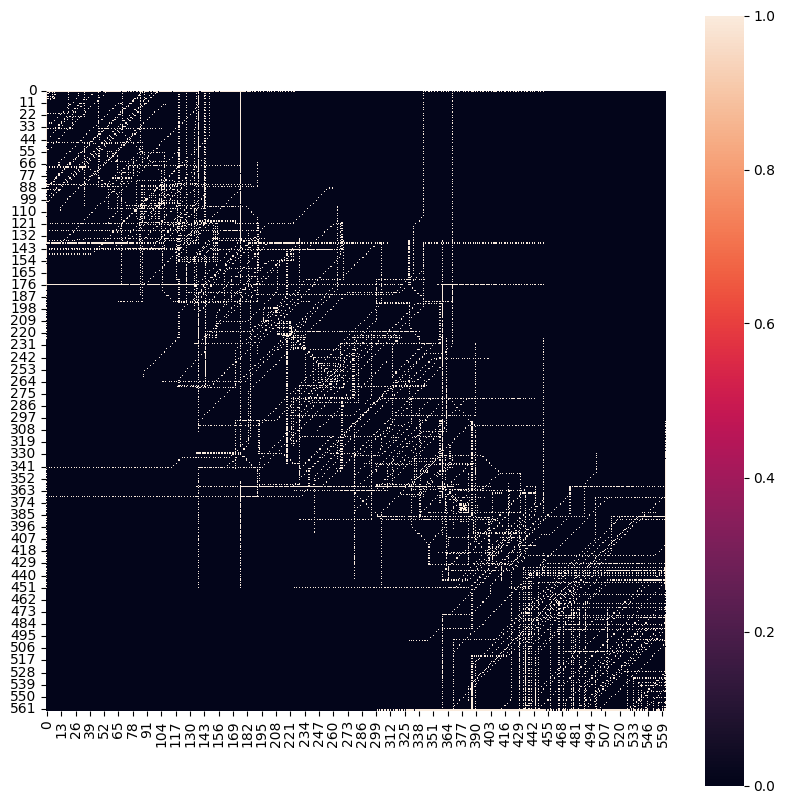

In [90]:
draw_interaction_heatmap(
    args['BEADSIZE'],
    path_to_coh_h5 = f'{folder_name}/Cohesins_positions.h5',
    path_to_cond_h5 = f'{folder_name}/Condensins_positions.h5',
    out_name = None,
    first_frame = 0,
    n_frames = None,
    save_each_frame = 1,
    out_resolution = int(4e3),
    interaction_presence_only = True,
    log_scale = True,
    figsize = (10,10),
#     sector = [[418e3, 475e3], [418e3, 475e3]],
    chunk = int(1e5),
)

MovieWriter stderr:
Error writing trailer of ./test_multiproc/sister.gif: Invalid argument



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-r', '22.22222222222222', '-loglevel', 'error', '-i', 'pipe:', '-filter_complex', 'split [a][b];[a] palettegen [p];[b][p] paletteuse', '-y', './test_multiproc/sister.gif']' returned non-zero exit status 255.

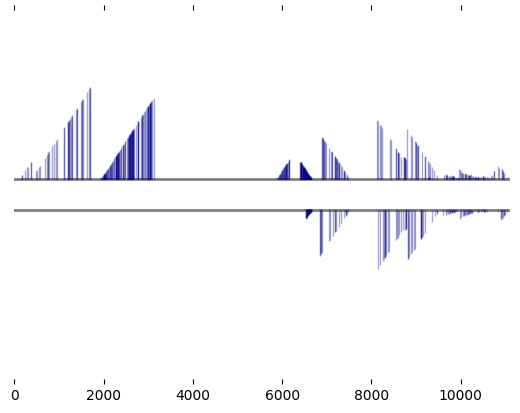

In [57]:
%%time
draw_gif_by_coords( 
    f'{folder_name}/sister.gif', 
    path_to_rnap_h5 = f'{folder_name}/RNAp_pos_brists.h5',
    path_to_coh_h5 = f'{folder_name}/Cohesins_positions.h5',
    path_to_cond_h5 = f'{folder_name}/Condensins_positions.h5',
    time_interval = args['TIMESTEP']*steps_wo_saving, 
    single_strand = False,
    first_frame = 0,
    n_frames = steps,
    save_each_frame = 1,
    shift_k = 0.2,
    rnap_heigh_factor = 10.0 / args['BEADSIZE'],
    arc_heigh_factor = 40.0,
)

In [ ]:
a = h5py.File(f'{folder_name}/RNAp_pos_brists.h5', mode='r')

In [218]:
stat_tmp = []
for i in range(len(a['positions'])):
    tmp = a['positions'][i]
    tmp = tmp[tmp>0]
    tmp = tmp[(tmp >= 133) & (tmp <= 611)]
    stat_tmp += list(abs(tmp[1:] - tmp[:-1]) * args['BEADSIZE'])
    tmp = a['positions'][i]
    tmp = tmp[tmp>0]
    tmp = tmp[(tmp >= 1340) & (tmp <= 1818)]
    stat_tmp += list(abs(tmp[1:] - tmp[:-1]) * args['BEADSIZE'])
    
np.mean(stat_tmp)

378.6035535813437

In [223]:
max(stat_tmp)

278

In [219]:
chosen_genes

type  chrom     start       end direction    gene_id  \
3856  transcript  chr11  16585973  16607555         +  FORW.7360   
3857  transcript  chr11  16604587  16616916         -   REV.7194   

     transcript_id         TPM      FPKM       cov    len      rnap_sep  
3856   FORW.7360.1  115.573546  9.603418  0.125753  21582    235.972686  
3857    REV.7194.1    0.691535  0.057462  0.001460  12329  22529.011162

In [217]:
chosen_genes_beads

[[133,
  1,
  611,
  0.01907000369540441,
  [(730, 486),
   (1996, 1636),
   (525, 76),
   (567, 83),
   (1347, 802),
   (732, 79),
   (897, 95),
   (1316, 446),
   (1188, 243),
   (2265, 1254),
   (3152, 2017),
   (1882, 650),
   (2137, 804),
   (2381, 959),
   (2106, 583),
   (3075, 1396),
   (2398, 549),
   (2031, 85),
   (2342, 346),
   (2830, 668),
   (2303, 73),
   (2898, 552),
   (3084, 591),
   (2903, 315),
   (3413, 684)]],
 [1818,
  -1,
  1340,
  0.01907000369540441,
  [(730, 486),
   (1996, 1636),
   (525, 76),
   (567, 83),
   (1347, 802),
   (732, 79),
   (897, 95),
   (1316, 446),
   (1188, 243),
   (2265, 1254),
   (3152, 2017),
   (1882, 650),
   (2137, 804),
   (2381, 959),
   (2106, 583),
   (3075, 1396),
   (2398, 549),
   (2031, 85),
   (2342, 346),
   (2830, 668),
   (2303, 73),
   (2898, 552),
   (3084, 591),
   (2903, 315),
   (3413, 684)]],
 [819,
  -1,
  545,
  0.0001997424550807305,
  [(1410, 1344),
   (2588, 2346),
   (1098, 626),
   (1244, 628),
   (2274, 12